# Coursera IBM Data Science Capstone Project #

Battle of the Neighborhoods


# 2. Data Preparation

On this section, we will prepare the data from our three data sources into a new dataset. First step is to process the Madrid Neighborhood data, which is available in a .shp file.

We will first import all libraries to be used on this section, and then proceed with the data wrangling.


In [1]:
# Import required python libraries
import pandas as pd
from geopy.geocoders import Nominatim 
import numpy as np
import json
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
#!conda install -c conda-forge geopandas
import folium
import requests
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import requests

# 2.1 Brussels Post Codes (Belgium)

First, we need to obtain the neighbourhood location information. A public data set for zipcodes in Belgium will be used to get the Zip Code, Neigborhood and the coordinates for all regions. 

In [2]:
url  = "https://github.com/jief/zipcode-belgium/blob/master/zipcode-belgium.csv"
p = requests.get(url)
df_html = pd.read_html(url, na_values = ['Not assigned'])[0]
df_html.reset_index(inplace=True)
df_html.head()



,index,Unnamed: 0,1000,Bruxelles,4.351697,50.8465573
0,0,NaN,1020,Laeken,4.348713,50.883392
1,1,NaN,1030,Schaerbeek,4.373712,50.867604
2,2,NaN,1040,Etterbeek,4.389510,50.836851
3,3,NaN,1050,Ixelles,4.381571,50.822285
4,4,NaN,1060,Saint-Gilles,4.345668,50.826741


Unfortunately, the data set doesn't include column names, so we have to add them manually. 

In [3]:
df_html.columns = ["index", "Unnamed", "Zip Code", "Neighbourhood", "longitude", "latitude"]
df_html.head()

,index,Unnamed,Zip Code,Neighbourhood,longitude,latitude
0,0,NaN,1020,Laeken,4.348713,50.883392
1,1,NaN,1030,Schaerbeek,4.373712,50.867604
2,2,NaN,1040,Etterbeek,4.389510,50.836851
3,3,NaN,1050,Ixelles,4.381571,50.822285
4,4,NaN,1060,Saint-Gilles,4.345668,50.826741


That looks better! Now we want to get rid of the unnecessary columns and exclude all entries outside of Brussels. The zip code from Brussels go from 1000 to 1210. Therefore, we can simply exclude all entries with a Zip code higher then 1210.

In [4]:
df_html = df_html[['Zip Code','Neighbourhood','longitude','latitude']]
df_Brussels = df_html[df_html['Zip Code'] <= 1210] 
df_Brussels

,Zip Code,Neighbourhood,longitude,latitude
0,1020,Laeken,4.348713,50.883392
1,1030,Schaerbeek,4.373712,50.867604
2,1040,Etterbeek,4.389510,50.836851
3,1050,Ixelles,4.381571,50.822285
4,1060,Saint-Gilles,4.345668,50.826741
5,1070,Anderlecht,4.312340,50.838141
6,1080,Molenbeek-Saint-Jean,4.322778,50.854355
7,1081,Koekelberg,4.325708,50.862263
8,1082,Berchem-Sainte-Agathe,4.292702,50.863984
9,1083,Ganshoren,4.317510,50.871240


# 2.2 Brussels Neighbourhood visualization


First, we optain the coordinates for Brussels from the dataset we created before, by simply averaging Latitude/Longitude of the dataset.

In [5]:
lat_brussels = df_Brussels['latitude'].mean()
lon_brussels = df_Brussels['longitude'].mean()
print('The geographical coordinates of Brussels are {}, {}'.format(lat_brussels, lon_brussels))

The geographical coordinates of Brussels are 50.84856464047619, 4.366170640079248


Now, we cant to create a dictionary to map a random color to each Zip Code. 

In [6]:
map_brussels = folium.Map(location=[lat_brussels, lon_brussels], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df_Brussels['longitude'], df_Brussels['latitude'], df_Brussels['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    label_text = "neighbourhood"
    folium.CircleMarker(
        [lat, lng],
        tooltip = label_text,
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_brussels)  
    
map_brussels

# 2.3 Using Foursquare API

In [7]:
# The code was removed by Watson Studio for sharing.

In [8]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [9]:
brussels_venues = getNearbyVenues(names=df_Brussels['Neighbourhood'],
                                latitudes=df_Brussels['latitude'],
                                longitudes=df_Brussels['longitude'])

Laeken
Schaerbeek
Etterbeek
Ixelles
Saint-Gilles
Anderlecht
Molenbeek-Saint-Jean
Koekelberg
Berchem-Sainte-Agathe
Ganshoren
Jette
Neder-Over-Heembeek
Haren
Evere
Woluwe-Saint-Pierre
Auderghem
Watermael-Boitsfort
Uccle
Forest
Woluwe-Saint-Lambert
Saint-Josse-Ten-Noode


In [10]:
brussels_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Laeken,50.883392,4.348713,Les Jardins du Fleuriste,50.885331,4.345573,Park
1,Laeken,50.883392,4.348713,Steylemans,50.883638,4.344359,Electronics Store
2,Laeken,50.883392,4.348713,Pizzicato 2,50.884178,4.344376,Italian Restaurant
3,Laeken,50.883392,4.348713,Parc Sobieskipark (Sobieskipark),50.884826,4.346192,Park
4,Laeken,50.883392,4.348713,Prins Leopoldsquare / Square Prince Léopold (P...,50.884269,4.342278,Plaza


Let's count how many vanues we have found:

In [11]:
print('A total of {} venues were found in Brussels'.format(brussels_venues.shape[0]))

A total of 563 venues were found in Brussels


In [12]:


# Count the number of locations per Venue Category in Madrid
brussels_venues.groupby('Venue Category').count()['Neighborhood'].sort_values(ascending=False).head(10)



Venue Category
Italian Restaurant    30
Bar                   28
Plaza                 28
Supermarket           26
French Restaurant     24
Bakery                20
Restaurant            17
Sandwich Place        17
Park                  15
Snack Place           14
Name: Neighborhood, dtype: int64

As there are many italian Restaurants already, we want to closer analyse in which Neighbourhood they are located. To do so, we filter on Italian Restaurants.

In [13]:
df_Italian = brussels_venues[brussels_venues['Venue Category'] == "Italian Restaurant"] 
df_Italian


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
2,Laeken,50.883392,4.348713,Pizzicato 2,50.884178,4.344376,Italian Restaurant
9,Laeken,50.883392,4.348713,Le Regal,50.880408,4.347658,Italian Restaurant
30,Schaerbeek,50.867604,4.373712,Osteria Delle Stelle,50.863684,4.376285,Italian Restaurant
32,Schaerbeek,50.867604,4.373712,La Buca Di Bacco,50.863640,4.376638,Italian Restaurant
40,Schaerbeek,50.867604,4.373712,Luigi,50.869470,4.372419,Italian Restaurant
66,Etterbeek,50.836851,4.389510,Il Veliero,50.836598,4.382442,Italian Restaurant
71,Etterbeek,50.836851,4.389510,Il Sorriso,50.836755,4.383504,Italian Restaurant
83,Etterbeek,50.836851,4.389510,Il Veliero da Gaspare,50.836648,4.382471,Italian Restaurant
143,Saint-Gilles,50.826741,4.345668,La Tavernetta,50.824627,4.347991,Italian Restaurant
145,Saint-Gilles,50.826741,4.345668,CiPiaCe Bruxelles,50.830600,4.345940,Italian Restaurant


In [14]:
venues_count = df_Italian.groupby(['Neighborhood'])["Venue"].count().to_frame()
venues_count

,Venue
Neighborhood,
Auderghem,3
Etterbeek,3
Evere,1
Ganshoren,3
Jette,1
Laeken,2
Saint-Gilles,3
Saint-Josse-Ten-Noode,4
Schaerbeek,3


The title needs to be fixed before creating a graph. Also, the Neighbourhoods will be sorted by the number of Italian Restaurants.

In [15]:
venues_count.rename(columns={'Venue':'N_venues'}, inplace=True)
venues_count.reset_index(inplace=True)
venues_count.sort_values(by='N_venues', ascending=False, inplace=True)

In [16]:
sns.set()
sns.set(rc={'figure.figsize':(12,5)})

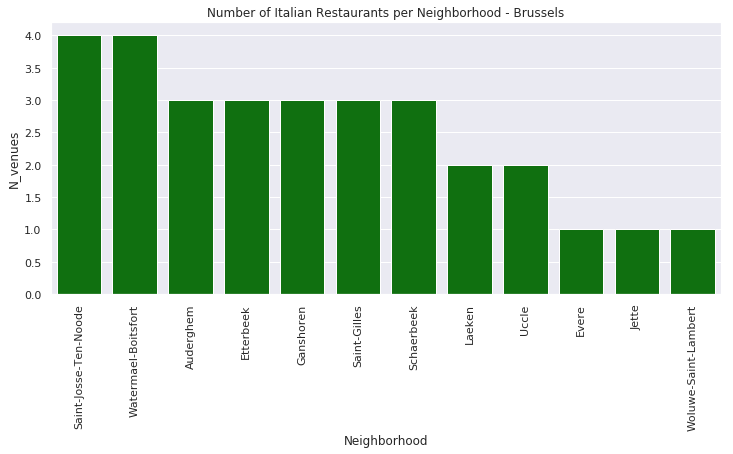

In [32]:
ax = sns.barplot(x='Neighborhood',y='N_venues',data=venues_count, color='green')
ax.set_title('Number of Italian Restaurants per Neighborhood - Brussels')
ax.set_xticklabels(labels=venues_count['Neighborhood'],rotation=90);

We also want to look at the location of the French Restaurants

In [44]:
df_france = brussels_venues[brussels_venues['Venue Category'] == "French Restaurant"] 
df_france


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
35,Schaerbeek,50.867604,4.373712,La Fantaisie,50.863712,4.376798,French Restaurant
72,Etterbeek,50.836851,4.389510,Origine,50.836744,4.383398,French Restaurant
93,Etterbeek,50.836851,4.389510,Midi 50,50.839562,4.391530,French Restaurant
110,Ixelles,50.822285,4.381571,Le Grenier d'Elvire,50.818698,4.383847,French Restaurant
115,Ixelles,50.822285,4.381571,L'Improbable,50.820800,4.386660,French Restaurant
130,Saint-Gilles,50.826741,4.345668,Le 203,50.825965,4.346444,French Restaurant
148,Saint-Gilles,50.826741,4.345668,Café des Spores,50.823400,4.342740,French Restaurant
155,Saint-Gilles,50.826741,4.345668,La Buvette,50.823400,4.343160,French Restaurant
179,Saint-Gilles,50.826741,4.345668,Le Damoiselle,50.823807,4.348266,French Restaurant
242,Koekelberg,50.862263,4.325708,Le Scénario,50.863568,4.329749,French Restaurant


In [45]:
venues_f = df_france.groupby(['Neighborhood'])["Venue"].count().to_frame()
venues_f.rename(columns={'Venue':'N_venues_F'}, inplace=True)
venues_f.reset_index(inplace=True)
venues_f.sort_values(by='N_venues_F', ascending=False, inplace=True)
venues_f

,Neighborhood,N_venues_F
7,Saint-Gilles,4
0,Auderghem,3
10,Uccle,3
2,Etterbeek,2
4,Ixelles,2
11,Watermael-Boitsfort,2
12,Woluwe-Saint-Lambert,2
1,Berchem-Sainte-Agathe,1
3,Forest,1
5,Koekelberg,1


We will now create a dataframe with both Italian and French Restaurants

In [46]:
merged = venues_count.merge(venues_f, left_on='Neighborhood', right_on='Neighborhood')

In [47]:
merged['Restaurants'] = merged['N_venues'] + merged['N_venues_F']

In [48]:
merged.sort_values(by='Restaurants', ascending=False, inplace=True)

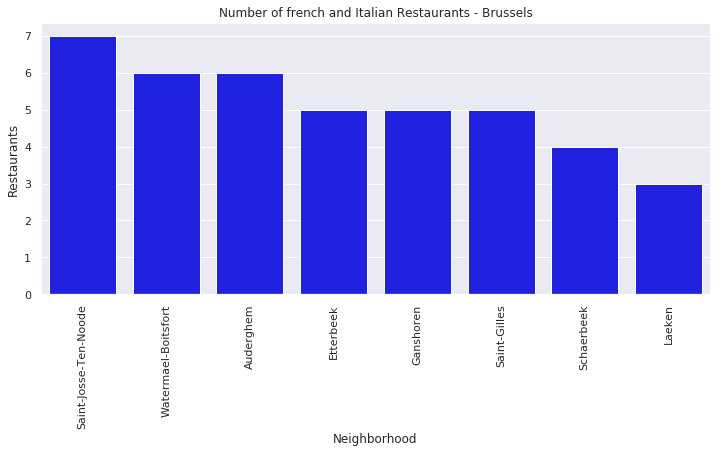

In [49]:
ax = sns.barplot(x='Neighborhood',y='Restaurants',data=merged, color='blue')
ax.set_title('Number of french and Italian Restaurants - Brussels')
ax.set_xticklabels(labels=venues_count['Neighborhood'],rotation=90);